# Implement random forest from scratch, start from decision treee

## Decision tree

Decision tree is a machine learning method that makes sequential binary choices at
each step based on one feature value per step, until a final value is assigned to the
target variable.

A decision tree on whether to date or not
```
        weather
        /     \
      cold   hot
      /         \
    location   time
    /  \        / \
   in  out  early  late
  /      \    /     \
 Yes     No  No    Yes
```

It's called decision tree because one needs to transverse through a tree to
make a final decision. Machine model comes in when figuring out how the tree should be
constructed, i.e. what features to use and what values are used to split at each features.

### Entropy & Where to split?

At each step, ideally we split a heterogeneous pool into two homogeneous pools.
To get close to that, we aim to reduce total entropy. This measure is also called
information gain. We pick the value such that information gain is maximized when
split optimally.

Assuming binary classification, entropy is
$$Entropy = -p_0\log_2 p_0 - p_1\log_2 p_1$$
Where $p_0, p_1$ is the proprotion of samples in the two classes respectively.

In [1]:
import math
import numpy as np
import pandas as pd

def entropy(Y):
    """
    sum of p0 log2(p0) + p1 log2(p1)
    """
    total_ent = 0
    size = len(Y)
    p = sum([y == 1 for y in Y]) / size
    if p == 0 or p == 1:
        return 0
    else:
        return -p * math.log(p, 2) - (1 - p) * math.log(1 - p, 2)

Sanity check entropy calculation. It should be like a bell

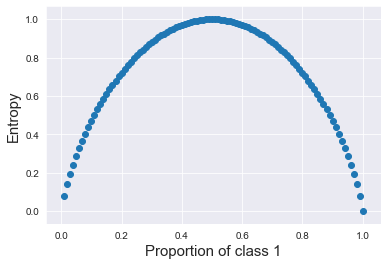

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

samples = [[0] * x + [1] * (100 - x) for x in range(100)]
proportions = [sum(s) / 100 for s in samples]
entropies = [entropy(s) for s in samples]
plt.plot()
plt.scatter(proportions, entropies)
plt.xlabel("Proportion of class 1", fontsize=15)
plt.ylabel("Entropy", fontsize=15)
plt.show()

An example of how we can use entropy reduction to guide spliting

In [4]:
before = [0] * 10 + [1] * 10
print("Entropy before splitting:", entropy(before))

split1 = [0] * 8 + [1] *2
split2 = [0] * 2 + [1] * 8
entropy_good = entropy(split1) * len(split1) / len(before) \
    + entropy(split2) * len(split2) / len(before)
print("Entropy after a good split", entropy_good)

split1 = [0] * 6 + [1] *4
split2 = [0] * 4 + [1] * 6
entropy_bad = entropy(split1) * len(split1) / len(before) \
    + entropy(split2) * len(split2) / len(before)
print("Entropy after a bad split", entropy_bad)

Entropy before splitting: 1.0
Entropy after a good split 0.7219280948873623
Entropy after a bad split 0.9709505944546686


For any given feature, we want to find the split where entropy reduction is maximized.
Iterate through all possible splitting point to do so.
To find the best feature to split first, do an exaustive search for all splitting points
of all features.

First implement a method to find a optimal splitting point for one feature

In [5]:
def split_entropy(values, labels):
    zipped = list(zip(values, labels))
    zipped.sort(key=lambda x: x[0])
    best_split, best_entr = values[0], entropy(labels)
    size = len(labels)
    for point in zipped:
        # split samples based on split value
        small_points = [p[1] for p in zipped if p[0] <= point[0]]
        large_points = [p[1] for p in zipped if p[0] > point[0]]
        if not small_points or not large_points:
            continue
        # calculate new entropy
        sum_entropy = entropy(small_points) * len(small_points) / size\
            + entropy(large_points) * len(large_points) / size
        # update best entropy if necessary
        if sum_entropy < best_entr:
            best_split, best_entr = point[0], sum_entropy
    return best_split, best_entr

# Example
split_entropy([1, 2, 3, 4], [0, 0, 0, 0])

(1, 0)

### Tree Nodes

We use nodes to represent each decision point. The decision to branch left or
right is determined by the feature value of the sample. For each node,
we need to know which feature it's associated with and what value to use as the splitting
point. For analytic purpose later, also make a `height` method to get height of the subtree
rooted at the node.

In [6]:
class Node:
    def __init__(self):
        self.feature = None
        self.split = None
        # left/right is either a node or a value. If it's a value then this node
        # is a leaf
        self.left = None
        self.right = None
    def move(self, val):
        """Move to left or right by comparing sample value to the splitting point"""
        if val <= self.split:
            return self.left
        else:
            return self.right
    def height(self):
        """Get the height of the tree rooted at this node"""
        if isinstance(self.left, float):
            return 1
        else:
            return 1 + max([self.left.height(), self.right.height()])

### Decision Tree

A basic ID3 decision tree model is no more than a wrapper class that holds a tree. During
training phase, it deterministically constructs nodes one by one, picking the best
splitting value of the best feature at each iteration. This process is greedy and
exaustive. To make a prediction, it transverse through the entire tree based on samples'
values at each feature, until a leaf is reached.

In [7]:
class DecisionTree:
    def __init__(self):
        self.root = None

    def fit(self, df, features, target):
        self.root = self._make_node(df, features, target)

    def predict(self, df):
        # transverse the tree for each data point
        pred = df.apply(lambda row: self._transverse(self.root, row), axis=1)
        return pred

    def _best_feature(self, df, features, target):
        """
        return the best feature given a set of feature values and a target.
        Store everything in a dataframe and let user specify which feature
        columns to use and which columns corresponds to the binary target
        """
        best_split, best_entro, best_feature = None, None, None
        # Try all features. At each iteration update the best option.
        for feature in features:
            this_split, this_entro = split_entropy(df[feature].tolist(), df[target])
            if best_split is None or best_entro > this_entro:
                best_split, best_entro, best_feature = this_split, this_entro, feature
        return best_split, best_feature

    def _make_node(self, df, features, target):
        node = Node()
        # Use the best splitting value of the best feature out of all.
        node.split, node.feature = self._best_feature(df, features, target)
        # Divide the samples into two subsets and use them to continue
        # subtree construction
        small_points = df[df[node.feature] <= node.split]
        large_points = df[df[node.feature] > node.split]
        # if No more split, return most frequent target value
        if small_points.shape[0] == 0 or large_points.shape[0] == 0:
            node.left = float(df[target].mode().iloc[0])
            node.right = float(df[target].mode().iloc[0])
        else:
            node.left = self._make_node(small_points, features, target)
            node.right = self._make_node(large_points, features, target)
        return node

    def _walk_node(self, node, row):
        # Go to the next decision point or leaf
        return node.move(row[node.feature])

    def _transverse(self, node, row):
        # Transverse nodes until a target (leaf) value is reached
        next_location = self._walk_node(node, row)
        while not isinstance(next_location, float):
            next_location = self._walk_node(next_location, row)
        return next_location

    def depth(self):
        return self.root.height()

### Plant some trees

Use above simple tree to fit breast cancer data, a binary classification problem

In [8]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

data = load_breast_cancer()
df = pd.DataFrame(data['data'])
columns = [c for c in df.columns]
df['target'] = data['target']
# Count values to make sure accuracy makes sense (balanced class)
df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

Fit the tree with the entire sample. This should create a HUGE tree that is 100% overfit and gives 100% accuracy, since the tree keeps making nodes until all samples are settled into homogeneous leaves.

In [9]:
tree = DecisionTree()
tree.fit(df, features=columns, target='target')

In [10]:
pred = tree.predict(df)
acc = accuracy_score(y_pred=pred, y_true=df['target'])
print("Accuracy is", acc)
print("Tree depth is", tree.depth())

Accuracy is 1.0
Tree depth is 11


Fit the tree with a subset of samples so that we can set aside test data. Compare performance
on test vs training data to confirm overfitting.

In [11]:
tree = DecisionTree()
train = df.head(200)
test = df.tail(300)
tree.fit(train, features=columns, target='target')
pred = tree.predict(test)
acc = accuracy_score(y_pred=pred, y_true=test['target'])
print("Accuracy is", acc)
print("Tree depth is", tree.depth())

Accuracy is 0.83
Tree depth is 10


### Overcome overfitting

There are many ways to avoid overfitting a tree, such as
 - Limit tree depth
 - Stop node construction once there are fewer than X number of samples in either split
 - Prune the tree later by removing leaves that do not contribute to prediction much
 - Use a subset of features
 - Fit on a subset of samples
 - Set a lower bound of information gain to continue node construction
 - Many more!

Those are all trade-offs between bias and variation to avoid fitting on errors
in the samples. Here's where a technique called `random forest` comes in. The general
idea is that by creating a forest of trees and all of them to make prediction, then
we mitigate overfitting. This is an ensemble method, where multiple estimators collectively
make a decision on the outcome.

## A Simple Random Forest Model

To demonstrate that random forest enhances the power of decision tree, let's implement
a classifier with 100 trees. Instead of fitting all samples with all features, each
tree is fed with 66% of traning samples and 2/3 of the features. See what happens

In [12]:
class SimpleForest:
    def __init__(self, n_trees=100):
        self.trees = [DecisionTree() for _ in range(n_trees)]
    
    def fit(self, df, features, target):
        for tree in self.trees:
            subset = df.sample(frac=0.66)
            sub_features = np.random.choice(features, int(2 * len(features) / 3))
            tree.fit(subset, sub_features, target)
    
    def predict(self, df):
        pred_list = [tree.predict(df) for tree in self.trees]
        combined = pd.concat(pred_list, axis=1)
        return combined.mode(axis=1).iloc[:, 0].tolist()

The following will take a few minutes due to inefficient implementation

In [13]:
forest = SimpleForest()
forest.fit(train, features=columns, target='target')

In [14]:
pred = forest.predict(test)

In [15]:
pred = forest.predict(train)
acc = accuracy_score(y_pred=pred, y_true=train['target'])

pred_tree = tree.predict(train)
tree_acc = accuracy_score(y_pred=pred_tree, y_true=train['target'])

print("Training accuracy of random forest:", acc)
print("Training accuracy of decision tree:", tree_acc)

pred = forest.predict(test)
acc = accuracy_score(y_pred=pred, y_true=test['target'])

pred_tree = tree.predict(test)
tree_acc = accuracy_score(y_pred=pred_tree, y_true=test['target'])

print("Test accuracy of random forest:", acc)
print("Test accuracy of decision tree:", tree_acc)

Training accuracy of random forest: 1.0
Training accuracy of decision tree: 1.0
Test accuracy of random forest: 0.93
Test accuracy of decision tree: 0.83


This data set is simple enough that random forest manages to get 100% accuracy on
training samples and is still robust against unseen test samples. In most cases,
it does not achieve 100% training accuracy, but that's not a problem and probably
a good thing.

Optimizations of decision tree can be used to random forest as well. Besides,
random forest has additional optimization such as
 - Number of trees
 - Number of features to be sampled at each tree
 - How sampling is done for fitting each tree
 - Voting method at prediction time
 - Adding different weights to trees
 - More...